In [1]:
import copy
import datetime as dt
import importlib # needed so that we can reload packages
import matplotlib.pyplot as plt
import os, os.path
import numpy as np
import pandas as pd
import pathlib
import sys
import time
from typing import Union
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")

##  IMPORT SISEPUEDE EXAMPLES AND TRANSFORMERS

from sisepuede.manager.sisepuede_examples import SISEPUEDEExamples
from sisepuede.manager.sisepuede_file_structure import SISEPUEDEFileStructure
import sisepuede.core.support_classes as sc
import sisepuede.transformers as trf
import sisepuede.utilities._plotting as spu
import sisepuede.utilities._toolbox as sf

sys.path.append(os.path.join('../', 'utils'))

from TransformationUtils import ExcelYAMLHandler, StrategyCSVHandler
from GeneralUtils import GeneralUtils

In [2]:
%load_ext autoreload
%autoreload 2

### Initial Set up

Make sure to edit the config yaml under croatia/config_files/croatia_config.yaml

You can also create a new config yaml



In [3]:
g_utils = GeneralUtils()

In [4]:
# Set up dir paths

dir_cur = pathlib.Path(os.getcwd())
dir_project = dir_cur.parent
dir_data = dir_cur.joinpath("data")
dir_config = dir_cur.joinpath("config_files")
dir_transformations = dir_cur.joinpath("transformations")
dir_utils = dir_project.joinpath("utils")
strategies_definitions_file_path = dir_transformations.joinpath("strategy_definitions.csv")
strategy_mapping_file_path = dir_utils.joinpath("strategy_mapping.yaml")

In [5]:
# Load config file, double check your parameters are correct

yaml_file_path = os.path.join(dir_config, "uganda_config.yaml")
config_params = g_utils.get_yaml_values(yaml_file_path)

country_name = config_params['country_name']
ssp_input_file_name = config_params['ssp_input_file_name']
ssp_transformation_cw = config_params['ssp_transformation_cw']


Country Name: uganda
SSP Input File Name: sisepuede_inputs_uganda.csv
SSP Transformation CW: ssp_uganda_transformation_cw.xlsx


In [6]:
# Set up SSP objects

fp_data_base = dir_data.joinpath(ssp_input_file_name)

file_struct = SISEPUEDEFileStructure()

matt = file_struct.model_attributes
regions = sc.Regions(matt)
time_periods = sc.TimePeriods(matt)

### Making sure our input file has the correct format and correct columns
We use an example df with the complete fields and correct format to make sure our file is in the right shape

In [7]:
##  BUILD BASE INPUTS

df_inputs_raw = pd.read_csv(fp_data_base)

# pull example data to fill in gaps
examples = SISEPUEDEExamples()
df_inputs_example = examples.input_data_frame

In [8]:
df_inputs_example.head()

,region,time_period,avgload_trns_freight_tonne_per_vehicle_aviation,avgload_trns_freight_tonne_per_vehicle_rail_freight,avgload_trns_freight_tonne_per_vehicle_road_heavy_freight,avgload_trns_freight_tonne_per_vehicle_water_borne,avgmass_lvst_animal_buffalo_kg,avgmass_lvst_animal_cattle_dairy_kg,avgmass_lvst_animal_cattle_nondairy_kg,avgmass_lvst_animal_chickens_kg,...,ef_ippu_tonne_cf4_per_tonne_production_electronics,ef_ippu_tonne_cf4_per_tonne_production_metals,ef_ippu_tonne_c3f8_per_tonne_production_chemicals,ef_ippu_tonne_c3f8_per_tonne_production_electronics,ef_ippu_tonne_c4f10_per_mmm_gdp_product_use_ods_other,ef_ippu_tonne_c4f10_per_tonne_production_chemicals,ef_ippu_tonne_c6f14_per_mmm_gdp_product_use_ods_other,ef_ippu_tonne_c6f14_per_tonne_production_chemicals,ef_ippu_tonne_cc4f8_per_tonne_production_chemicals,ef_ippu_tonne_cc4f8_per_tonne_production_electronics
0,costa_rica,0,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,4.204879e-07,0.0,1.515048e-07,0.0,0.0,0.0,0.0,0.0,5.669821e-08
1,costa_rica,1,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,2.134675e-07,0.0,1.313925e-07,0.0,0.0,0.0,0.0,0.0,5.185820e-08
2,costa_rica,2,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,1.821067e-07,0.0,1.060066e-07,0.0,0.0,0.0,0.0,0.0,5.269348e-08
3,costa_rica,3,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,2.094712e-07,0.0,1.093024e-07,0.0,0.0,0.0,0.0,0.0,5.500450e-08
4,costa_rica,4,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,3.446161e-07,0.0,1.046451e-07,0.0,0.0,0.0,0.0,0.0,5.266081e-08


In [9]:
# Checks if there are any differences in columns between the example df and our df
g_utils.compare_dfs(df_inputs_example, df_inputs_raw)


Columns in df_example but not in df_input: {'nemomod_entc_fixed_cost_fp_hydrogen_reformation_ccs_mm_usd_per_gw', 'nemomod_entc_capital_cost_fp_hydrogen_reformation_ccs_mm_usd_per_gw', 'ef_enfu_stationary_combustion_tonne_ch4_per_tj_fuel_ammonia', 'strategy_id', 'nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_electricity', 'frac_enfu_fuel_demand_imported_pj_fuel_ammonia', 'nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_natural_gas', 'nemomod_entc_input_activity_ratio_fuel_production_fp_ammonia_production_electricity', 'nemomod_entc_grid_power_constraint_mmm_usd', 'ef_enfu_stationary_combustion_tonne_n2o_per_tj_fuel_ammonia', 'energydensity_gravimetric_enfu_gj_per_tonne_fuel_ammonia', 'nemomod_entc_emissions_activity_ratio_scalar_fp_hydrogen_reformation_ccs_co2', 'ef_enfu_combustion_tonne_co2_per_tj_fuel_ammonia', 'nemomod_entc_frac_min_share_production_fp_hydrogen_reformation_ccs', 'nemomod_entc_output_activity_ratio_fuel_pro

In [10]:
# Fixes differences and makes sure that our df is in the correct format.
# Note: Edit this if you need more changes in your df

df_inputs_raw = df_inputs_raw.rename(columns={'period':'time_period'})
df_inputs_raw_complete = g_utils.add_missing_cols(df_inputs_example, df_inputs_raw.copy())
df_inputs_raw_complete = g_utils.remove_additional_cols(df_inputs_example, df_inputs_raw_complete.copy())
df_inputs_raw_complete = df_inputs_raw_complete.drop(columns='iso_code3', errors='ignore')
df_inputs_raw_complete.head()

,region,pij_lndu_forests_primary_to_croplands,pij_lndu_forests_mangroves_to_wetlands,yf_agrc_nuts_tonne_ha,ef_lndu_conv_forests_secondary_to_other_gg_co2_ha,ef_lndu_conv_forests_secondary_to_wetlands_gg_co2_ha,ef_lndu_conv_other_to_forests_primary_gg_co2_ha,pij_lndu_forests_mangroves_to_forests_secondary,ef_lndu_conv_wetlands_to_settlements_gg_co2_ha,pij_lndu_grasslands_to_forests_secondary,...,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_electrolysis_water,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_electricity,energydensity_gravimetric_enfu_gj_per_tonne_fuel_ammonia,energydensity_gravimetric_enfu_gj_per_tonne_fuel_water,frac_trns_fuelmix_water_borne_ammonia,nemomod_entc_output_activity_ratio_fuel_production_fp_ammonia_production_ammonia,nemomod_entc_output_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_hydrogen,nemomod_entc_frac_min_share_production_fp_hydrogen_reformation_ccs,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_natural_gas,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_oil
0,uganda,0.009591,0,0.6913,0.083964,0.087912,0,0,0,0,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
1,uganda,0.011771,0,0.6497,0.083964,0.087912,0,0,0,0,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
2,uganda,0.011129,0,0.6995,0.083964,0.087912,0,0,0,0,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
3,uganda,0.011167,0,0.6757,0.083964,0.087912,0,0,0,0,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
4,uganda,0.011205,0,0.9438,0.083964,0.087912,0,0,0,0,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0


In [11]:
# Double checking that our df is in the correct shape (Empty sets should be printed to make sure everything is Ok!)
g_utils.compare_dfs(df_inputs_example, df_inputs_raw_complete)

Columns in df_example but not in df_input: set()
Columns in df_input but not in df_example: set()


In [12]:
# Checking if there are any columns with null values in it
columns_with_na = df_inputs_raw_complete.columns[df_inputs_raw_complete.isna().any()].tolist()

print(columns_with_na)

['exports_enfu_pj_fuel_kerosene', 'frac_enfu_fuel_demand_imported_pj_fuel_kerosene', 'frac_enfu_fuel_demand_imported_pj_fuel_oil', 'exports_enfu_pj_fuel_coal', 'frac_enfu_fuel_demand_imported_pj_fuel_electricity', 'exports_enfu_pj_fuel_natural_gas', 'exports_enfu_pj_fuel_gasoline', 'exports_enfu_pj_fuel_oil', 'frac_enfu_fuel_demand_imported_pj_fuel_hydrocarbon_gas_liquids', 'exports_enfu_pj_fuel_electricity', 'exports_enfu_pj_fuel_diesel', 'frac_enfu_fuel_demand_imported_pj_fuel_natural_gas', 'frac_enfu_fuel_demand_imported_pj_fuel_coal', 'frac_enfu_fuel_demand_imported_pj_fuel_crude', 'frac_enfu_fuel_demand_imported_pj_fuel_gasoline', 'exports_enfu_pj_fuel_crude', 'exports_enfu_pj_fuel_hydrocarbon_gas_liquids', 'frac_enfu_fuel_demand_imported_pj_fuel_diesel']


In [13]:
# Checking region to avoid copy errors
df_inputs_raw_complete['region'].head()

0    uganda
1    uganda
2    uganda
3    uganda
4    uganda
Name: region, dtype: object

In [14]:
# Set region to country name
df_inputs_raw_complete['region'] = country_name
df_inputs_raw_complete['region'].head()

0    uganda
1    uganda
2    uganda
3    uganda
4    uganda
Name: region, dtype: object

In [15]:
df_inputs_raw_complete.head()

,region,pij_lndu_forests_primary_to_croplands,pij_lndu_forests_mangroves_to_wetlands,yf_agrc_nuts_tonne_ha,ef_lndu_conv_forests_secondary_to_other_gg_co2_ha,ef_lndu_conv_forests_secondary_to_wetlands_gg_co2_ha,ef_lndu_conv_other_to_forests_primary_gg_co2_ha,pij_lndu_forests_mangroves_to_forests_secondary,ef_lndu_conv_wetlands_to_settlements_gg_co2_ha,pij_lndu_grasslands_to_forests_secondary,...,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_electrolysis_water,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_electricity,energydensity_gravimetric_enfu_gj_per_tonne_fuel_ammonia,energydensity_gravimetric_enfu_gj_per_tonne_fuel_water,frac_trns_fuelmix_water_borne_ammonia,nemomod_entc_output_activity_ratio_fuel_production_fp_ammonia_production_ammonia,nemomod_entc_output_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_hydrogen,nemomod_entc_frac_min_share_production_fp_hydrogen_reformation_ccs,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_natural_gas,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_oil
0,uganda,0.009591,0,0.6913,0.083964,0.087912,0,0,0,0,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
1,uganda,0.011771,0,0.6497,0.083964,0.087912,0,0,0,0,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
2,uganda,0.011129,0,0.6995,0.083964,0.087912,0,0,0,0,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
3,uganda,0.011167,0,0.6757,0.083964,0.087912,0,0,0,0,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
4,uganda,0.011205,0,0.9438,0.083964,0.087912,0,0,0,0,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0


#  Let's try building transformations using this


In [16]:
transformers = trf.transformers.Transformers(
    {},
    df_input = df_inputs_raw_complete,
)

##  Instantiate some transformations. Make sure to run this cell to create the transformations folder for the first time or if you wish to overwrite

In [17]:
# set an ouput path and instantiate
if not dir_transformations.exists():
    trf.instantiate_default_strategy_directory(
        transformers,
        dir_transformations,
    )
else:
    print(f"Directory {dir_transformations} already exists. Skipping instantiation.")


Directory /home/tony-ubuntu/decision_sciences/sisepuede_region_nbs_tony_ver/uganda/transformations already exists. Skipping instantiation.


##  --HERE, CUSTOMIZE YOUR TRANSFORMATIONS AND STRATEGIES--

### Customizing transformations and strategies files using TransformationUtils.py classes

In [18]:
# Generate new transformation files based on the excel mapping file. 
# Make sure to have the most updated format for the excel file, check the one used in this notebook for reference.

cw_file_path = os.path.join(dir_data, ssp_transformation_cw)
excel_yaml_handler = ExcelYAMLHandler(excel_file=cw_file_path, yaml_directory='transformations')

In [19]:
# This creates transformation yaml files for each strategy in the excel file

# Use if its the first time you are running this
excel_yaml_handler.process_yaml_files()

# Use if you have already created the yaml files and just want to update them so the transformations with multiple params are not overwritten
# NOTE: This is a temporary solution, we need to find a better way to handle this
# excel_yaml_handler.process_yaml_files(overwrite_mult_param_transformations=False)

YAML file transformation_agrc_inc_conservation_agriculture.yaml for strategy strategy_priority_mitigation set to default because it does not have magnitude attribute
YAML file transformation_agrc_inc_conservation_agriculture.yaml for strategy strategy_aditional_actions set to default because it does not have magnitude attribute
YAML file transformation_agrc_inc_conservation_agriculture.yaml for strategy strategy_net_zero set to default because it does not have magnitude attribute
YAML file transformation_inen_shift_fuel_heat.yaml for strategy strategy_net_zero set to default because it does not have magnitude attribute
YAML file transformation_lsmm_inc_management_cattle_pigs.yaml for strategy strategy_net_zero set to default because it does not have magnitude attribute
YAML file transformation_lsmm_inc_management_other.yaml for strategy strategy_net_zero set to default because it does not have magnitude attribute
YAML file transformation_lsmm_inc_management_poultry.yaml for strategy st

In [20]:
# Load the transformations per strategy dictionary so we can pass it to the strategy handler
# You can also check here if the transformations in each strategy are correct
transformation_per_strategy_dict = excel_yaml_handler.get_transformations_per_strategy_dict()
transformation_per_strategy_dict

{'strategy_priority_mitigation': ['TX:AGRC:DEC_CH4_RICE_STRATEGY_PRIORITY_MITIGATION',
  'TX:AGRC:INC_CONSERVATION_AGRICULTURE_STRATEGY_PRIORITY_MITIGATION',
  'TX:AGRC:INC_PRODUCTIVITY_STRATEGY_PRIORITY_MITIGATION',
  'TX:ENTC:DEC_LOSSES_STRATEGY_PRIORITY_MITIGATION',
  'TX:ENTC:TARGET_CLEAN_HYDROGEN_STRATEGY_PRIORITY_MITIGATION',
  'TX:ENTC:TARGET_RENEWABLE_ELEC_STRATEGY_PRIORITY_MITIGATION',
  'TX:INEN:INC_EFFICIENCY_ENERGY_STRATEGY_PRIORITY_MITIGATION',
  'TX:INEN:INC_EFFICIENCY_PRODUCTION_STRATEGY_PRIORITY_MITIGATION',
  'TX:IPPU:DEC_CLINKER_STRATEGY_PRIORITY_MITIGATION',
  'TX:IPPU:DEC_DEMAND_STRATEGY_PRIORITY_MITIGATION',
  'TX:IPPU:DEC_HFCS_STRATEGY_PRIORITY_MITIGATION',
  'TX:LNDU:DEC_DEFORESTATION_STRATEGY_PRIORITY_MITIGATION',
  'TX:LNDU:DEC_SOC_LOSS_PASTURES_STRATEGY_PRIORITY_MITIGATION',
  'TX:LNDU:INC_REFORESTATION_STRATEGY_PRIORITY_MITIGATION',
  'TX:LNDU:INC_SILVOPASTURE_STRATEGY_PRIORITY_MITIGATION',
  'TX:LVST:INC_PRODUCTIVITY_STRATEGY_PRIORITY_MITIGATION',
  'TX:TRDE

### Creating new strategies
- You can create new strategies from scratch.
- You can also update existing ones.

In [21]:
# Creating new strategies by updating the strategy_definitions file.
# You can edit this to add yours, as many as you want.
csv_handler = StrategyCSVHandler(strategies_definitions_file_path, dir_transformations, strategy_mapping_file_path, transformation_per_strategy_dict)

# Uncomment for completly new strategies version
csv_handler.add_strategy(strategy_group='PFLO', description='Uganda NDC Priority Mitigation', yaml_file_suffix='priority_mitigation')
csv_handler.add_strategy(strategy_group='PFLO', description='Uganda NDC Aditional Actions', yaml_file_suffix='aditional_actions')
csv_handler.add_strategy(strategy_group='PFLO', description='Uganda NZ', yaml_file_suffix='net_zero')


Error: strategy_code PFLO:PRIORITY_MITIGATION already exists. Please use a different code or eliminate the existing one.
Error: strategy_code PFLO:ADITIONAL_ACTIONS already exists. Please use a different code or eliminate the existing one.
Error: strategy_code PFLO:NET_ZERO already exists. Please use a different code or eliminate the existing one.


In [22]:
# Uncomment to update the strategies that are currently in the strategy_definitions file

# csv_handler.add_strategy(strategy_group='PFLO', description='Uganda NDC Priority Mitigation', yaml_file_suffix='priority_mitigation', custom_id=6003, update_flag=True)
# csv_handler.add_strategy(strategy_group='PFLO', description='Uganda NDC Aditional Actions', yaml_file_suffix='aditional_actions', custom_id=6004, update_flag=True)
# csv_handler.add_strategy(strategy_group='PFLO', description='Uganda NZ', yaml_file_suffix='net_zero', custom_id=6005, update_flag=True)


In [23]:
# Set up the strategy codes you wish to run in ssp
strategies_to_run = [0, 6003, 6004, 6005]

### We finished adding new transformation files and strategies so lets load them back

In [24]:
# then, you can load this back in after modifying (play around with it)
transformations = trf.Transformations(
    dir_transformations,
    transformers = transformers,
)
tab = transformations.attribute_transformation.table

In [25]:
#  build the strategies -- will export to path
t0 = time.time()
strategies = trf.Strategies(
    transformations,
    export_path = "transformations",
    prebuild = True,
)

t_elapse = sf.get_time_elapsed(t0)
print(f"Strategies defined at {strategies.transformations.dir_init} initialized in {t_elapse} seconds")

Strategies defined at /home/tony-ubuntu/decision_sciences/sisepuede_region_nbs_tony_ver/uganda/transformations initialized in 4.27 seconds


In [26]:
strategies.attribute_table

,strategy_id,strategy_code,strategy,description,transformation_specification,baseline_strategy_id
0,0,BASE,Strategy TX:BASE,NaN,TX:BASE,1
1,1000,AGRC:DEC_CH4_RICE,Singleton - Default Value - AGRC: Improve rice...,NaN,TX:AGRC:DEC_CH4_RICE,0
2,1001,AGRC:DEC_EXPORTS,Singleton - Default Value - AGRC: Decrease Exp...,NaN,TX:AGRC:DEC_EXPORTS,0
3,1002,AGRC:DEC_LOSSES_SUPPLY_CHAIN,Singleton - Default Value - AGRC: Reduce suppl...,NaN,TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN,0
4,1003,AGRC:INC_CONSERVATION_AGRICULTURE,Singleton - Default Value - AGRC: Expand conse...,NaN,TX:AGRC:INC_CONSERVATION_AGRICULTURE,0
...,...,...,...,...,...,...
67,6001,PFLO:INC_IND_CCS,Singleton - Default Value - PFLO: Industrial c...,NaN,TX:PFLO:INC_IND_CCS,0
68,6002,PFLO:ALL,All Actions,All actions (unique by transformer),TX:AGRC:DEC_CH4_RICE|TX:AGRC:DEC_EXPORTS|TX:AG...,0
69,6003,PFLO:PRIORITY_MITIGATION,priority_mitigation,Uganda NDC Priority Mitigation,TX:ENTC:DEC_LOSSES_STRATEGY_PRIORITY_MITIGATIO...,0
70,6004,PFLO:ADITIONAL_ACTIONS,aditional_actions,Uganda NDC Aditional Actions,TX:WASO:DEC_CONSUMER_FOOD_WASTE_STRATEGY_ADITI...,0


##  Build our templates
- let's use the default variable groupings for LHS

In [27]:
# Building excel templates, make sure to include the strategies ids in the strategies attribute as well as the baseline (0)
df_vargroups = examples("variable_trajectory_group_specification")

strategies.build_strategies_to_templates(
    df_trajgroup = df_vargroups,
    include_simplex_group_as_trajgroup = True,
    strategies = strategies_to_run,
)

0

# Finally, load SISEPUEDE so that we can run it

In [28]:
country_name

'uganda'

In [29]:
# Make sure to change the regions attribute to your country name

import sisepuede as si
# timestamp_str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
ssp = si.SISEPUEDE(
    "calibrated",
    db_type = "csv",
    # id_str = f"sisepuede_run_2024-11-04T09:23:26.721580",
    initialize_as_dummy = False, # no connection to Julia is initialized if set to True
    regions = [country_name],
    strategies = strategies,
    try_exogenous_xl_types_in_variable_specification = True,
)

2025-01-24 10:41:58,106 - INFO - Successfully initialized SISEPUEDEFileStructure.
2025-01-24 10:41:58,109 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2025-01-24 10:41:58,110 - INFO - 	Setting export engine to 'csv'.
2025-01-24 10:41:58,112 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2025-01-24 10:41:58,113 - INFO - Successfully instantiated table ANALYSIS_METADATA
2025-01-24 10:41:58,114 - WARNING - No index fields found in ATTRIBUTE_DESIGN. Initializing index fields.
2025-01-24 10:41:58,115 - INFO - Successfully instantiated table ATTRIBUTE_DESIGN
2025-01-24 10:41:58,115 - WARNING - No index fields found in ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES. Initializing index fields.
2025-01-24 10:41:58,116 - INFO - Successfully instantiated table ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES
2025-01-24 10:41:58,117 - WARNING - No index fi

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Precompiling NemoMod...
Info Given NemoMod was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
   2520.8 ms  ? NemoMod
[ Info: Precompiling NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72] 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.
2025-01-24 10:42:57,589 - INFO - Successfully initialized JuMP optimizer from solver module HiGHS.
2025-01-24 10:42:57,622 - INFO - Successfully initialized SISEPUEDEModels.
2025-01-24 10:42:57,638 - INFO - Table ANALYSIS_METADATA successfully written to /home/tony-ubuntu/anaconda3/envs/ssp-data-env-2/lib/pyt

In [30]:
# This runs the model, make sure you edit key_stretegy with the strategy ids you want to execute include baseline (0)
dict_scens = {
    ssp.key_design: [0],
    ssp.key_future: [0],
    ssp.key_strategy: strategies_to_run,
}

ssp.project_scenarios(
    dict_scens,
    save_inputs = True,
)

2025-01-24 10:42:57,945 - INFO - 
***	STARTING REGION uganda	***



2025-01-24 10:43:02,367 - INFO - Trying run primary_id = 0 in region uganda
2025-01-24 10:43:02,368 - INFO - Running AFOLU model
2025-01-24 10:43:02,644 - INFO - AFOLU model run successfully completed
2025-01-24 10:43:02,645 - INFO - Running CircularEconomy model
2025-01-24 10:43:02,732 - INFO - CircularEconomy model run successfully completed
2025-01-24 10:43:02,732 - INFO - Running IPPU model
2025-01-24 10:43:02,860 - INFO - IPPU model run successfully completed
2025-01-24 10:43:02,861 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-01-24 10:43:02,910 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-01-24 10:43:02,983 - ERROR - Error running EnergyConsumption without Fugitive Emissions: Invalid summations found: some categories exceed the sum threshold.Energy fractions by category do not sum to 1. See definition of dict_arrs_trns_frac_fuel.
2025-01-24 10:43:02,98

{'uganda': [0, 69069, 70070, 71071]}

In [31]:
# df_run = ssp.generate_scenario_database_from_primary_key(0)
# df_run = df_run.get("iran")
# df_run.to_csv("/Users/usuario/Desktop/iran_baselines_temp.csv", encoding = "UTF-8", index = None, )

In [32]:
# Read input and output files
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)

## Some testing for Croatia (you can delete this section for a new country)

In [33]:
df_out.head()

,primary_id,region,time_period,area_agrc_crops_bevs_and_spices,area_agrc_crops_cereals,area_agrc_crops_fibers,area_agrc_crops_fruits,area_agrc_crops_herbs_and_other_perennial_crops,area_agrc_crops_nuts,area_agrc_crops_other_annual,...,yield_agrc_fruits_tonne,yield_agrc_herbs_and_other_perennial_crops_tonne,yield_agrc_nuts_tonne,yield_agrc_other_annual_tonne,yield_agrc_other_woody_perennial_tonne,yield_agrc_pulses_tonne,yield_agrc_rice_tonne,yield_agrc_sugar_cane_tonne,yield_agrc_tubers_tonne,yield_agrc_vegetables_and_vines_tonne
0,0,uganda,0,653577.302953,1.453791e+06,301651.062901,786247.906001,1.014581e+06,553725.215417,732481.395029,...,5.257378e+06,1.933859e+06,382790.241418,652177.018331,300188.194390,239526.137038,581306.726460,3.152255e+07,1.171608e+06,633809.379590
1,0,uganda,1,665049.195666,1.470278e+06,283851.366918,814137.816818,1.030789e+06,585259.846025,749512.789542,...,5.324335e+06,1.989562e+06,380296.296689,667584.100360,307635.916618,248085.379715,602127.753153,3.234568e+07,1.214395e+06,654363.222087
2,0,uganda,2,679952.960865,1.518562e+06,270625.985496,846952.194495,1.057474e+06,589990.474751,763556.472408,...,5.501950e+06,2.042091e+06,412777.267723,695987.550602,315749.488277,249644.767183,630184.459957,3.318820e+07,1.380181e+06,671330.231754
3,0,uganda,3,704623.160310,1.569708e+06,256188.207246,884760.111111,1.091101e+06,616655.324587,635015.125619,...,5.730307e+06,2.116542e+06,416786.352324,929955.158448,327300.424597,260727.512843,655555.317431,3.420272e+07,1.321604e+06,694819.014276
4,0,uganda,4,732486.604281,1.623098e+06,257708.685721,925883.893947,1.137890e+06,549013.906724,576944.828262,...,5.974336e+06,2.180839e+06,518366.250242,858702.066901,339942.543925,277882.773355,678472.411859,3.567134e+07,1.311159e+06,724525.640857


In [34]:
# Checking we've got an output df
df_out[[col for col in df_out.columns if 'subsector' in col]].head()

,emission_co2e_subsector_total_agrc,emission_co2e_subsector_total_frst,emission_co2e_subsector_total_ippu,emission_co2e_subsector_total_lndu,emission_co2e_subsector_total_lsmm,emission_co2e_subsector_total_lvst,emission_co2e_subsector_total_soil,emission_co2e_subsector_total_trww,emission_co2e_subsector_total_waso
0,17.975453,-9.619178,10.921639,29.206631,5.916175,59.695171,9.013405,6.667428,7.483595
1,18.294399,-9.384349,10.902157,34.226623,6.015630,60.706061,10.006267,7.006956,7.927891
2,18.657499,-9.089155,10.895643,30.388542,6.122062,61.766718,10.889341,7.333929,8.364133
3,18.904422,-8.829540,10.586835,33.904780,6.263003,63.216798,11.822212,7.751095,8.807088
4,19.171055,-8.561851,10.744358,40.432126,6.416962,64.805742,12.908553,8.179796,9.255100


In [35]:
df_out[[col for col in df_out.columns if 'subsector' in col]].tail()

,emission_co2e_subsector_total_agrc,emission_co2e_subsector_total_frst,emission_co2e_subsector_total_ippu,emission_co2e_subsector_total_lndu,emission_co2e_subsector_total_lsmm,emission_co2e_subsector_total_lvst,emission_co2e_subsector_total_soil,emission_co2e_subsector_total_trww,emission_co2e_subsector_total_waso
139,21.351803,-6.044287,2.245448,9.516053,7.649290,63.091970,3.712306,7.427697,8.833778
140,20.608448,-6.468143,1.950884,9.501816,7.551839,62.262560,3.922895,6.796968,8.322448
141,19.718253,-6.987578,1.675928,9.492640,7.444828,61.449683,4.471119,6.095318,7.823599
142,18.653445,-7.621713,1.420784,9.489795,7.328025,60.656210,4.624951,5.319305,7.341715
143,17.380494,-8.393695,1.193298,9.492441,7.201530,59.888607,4.657400,4.465381,6.880808


In [36]:
cement_df = df_out[['primary_id', 'time_period'] + [col for col in df_out.columns if 'prod_ippu_cement_tonne' in col]]
cement_df['year'] = cement_df['time_period'] + 2015
cement_df[cement_df.primary_id == 0]

,primary_id,time_period,prod_ippu_cement_tonne,year
0,0,0,2.646624e+07,2015
1,0,1,2.653830e+07,2016
2,0,2,2.658562e+07,2017
3,0,3,2.668106e+07,2018
4,0,4,2.677889e+07,2019
5,0,5,2.682390e+07,2020
6,0,6,2.687792e+07,2021
7,0,7,2.694815e+07,2022
8,0,8,2.703005e+07,2023
9,0,9,2.711220e+07,2024


In [37]:
mining_df = df_out[['primary_id', 'time_period'] + [col for col in df_out.columns if 'prod_ippu_mining_tonne' in col]]
mining_df['year'] = mining_df['time_period'] + 2015
mining_df[mining_df.primary_id == 0]

,primary_id,time_period,prod_ippu_mining_tonne,year
0,0,0,4.482526e+05,2015
1,0,1,4.589680e+05,2016
2,0,2,4.661541e+05,2017
3,0,3,4.808471e+05,2018
4,0,4,4.963274e+05,2019
5,0,5,5.036515e+05,2020
6,0,6,5.125575e+05,2021
7,0,7,5.243156e+05,2022
8,0,8,5.383069e+05,2023
9,0,9,5.526715e+05,2024


In [38]:
df_inputs_raw_complete['lndu_reallocation_factor'].mean()

0.5

In [39]:
df_in['lndu_reallocation_factor'].mean()

0.3333333333333333

In [40]:
df_inputs_raw_complete['elasticity_ippu_cement_production_to_gdp'].head()

0    0.056947
1    0.056947
2    0.056947
3    0.056947
4    0.056947
Name: elasticity_ippu_cement_production_to_gdp, dtype: float64

In [41]:
df_in[['primary_id', 'time_period', 'elasticity_ippu_cement_production_to_gdp']].head()

,primary_id,time_period,elasticity_ippu_cement_production_to_gdp
0,0,0,0.056947
1,0,1,0.056947
2,0,2,0.056947
3,0,3,0.056947
4,0,4,0.056947


In [42]:
[col for col in df_out.columns if 'lvst' in col]

['demand_lvst_buffalo',
 'demand_lvst_cattle_dairy',
 'demand_lvst_cattle_nondairy',
 'demand_lvst_chickens',
 'demand_lvst_goats',
 'demand_lvst_horses',
 'demand_lvst_mules',
 'demand_lvst_pigs',
 'demand_lvst_sheep',
 'emission_co2e_ch4_lvst_entferm_buffalo',
 'emission_co2e_ch4_lvst_entferm_cattle_dairy',
 'emission_co2e_ch4_lvst_entferm_cattle_nondairy',
 'emission_co2e_ch4_lvst_entferm_chickens',
 'emission_co2e_ch4_lvst_entferm_goats',
 'emission_co2e_ch4_lvst_entferm_horses',
 'emission_co2e_ch4_lvst_entferm_mules',
 'emission_co2e_ch4_lvst_entferm_pigs',
 'emission_co2e_ch4_lvst_entferm_sheep',
 'emission_co2e_subsector_total_lvst',
 'exportsadj_lvst_buffalo',
 'exportsadj_lvst_cattle_dairy',
 'exportsadj_lvst_cattle_nondairy',
 'exportsadj_lvst_chickens',
 'exportsadj_lvst_goats',
 'exportsadj_lvst_horses',
 'exportsadj_lvst_mules',
 'exportsadj_lvst_pigs',
 'exportsadj_lvst_sheep',
 'importssadj_lvst_buffalo',
 'importssadj_lvst_cattle_dairy',
 'importssadj_lvst_cattle_nonda

In [43]:
df_out[['primary_id', 'time_period'] + [col for col in df_out.columns if 'demand_lvst' in col]].head(36)

,primary_id,time_period,demand_lvst_buffalo,demand_lvst_cattle_dairy,demand_lvst_cattle_nondairy,demand_lvst_chickens,demand_lvst_goats,demand_lvst_horses,demand_lvst_mules,demand_lvst_pigs,demand_lvst_sheep
0,0,0,0.0,1.609820e+07,1.717336e+07,0.0,1.657714e+07,0.0,24446.179361,3.148541e+06,2.361493e+06
1,0,1,0.0,1.656785e+07,1.770491e+07,0.0,1.709544e+07,0.0,25210.786922,3.245995e+06,2.435327e+06
2,0,2,0.0,1.700340e+07,1.814987e+07,0.0,1.752155e+07,0.0,25839.946811,3.327574e+06,2.496028e+06
3,0,3,0.0,1.755901e+07,1.881775e+07,0.0,1.817936e+07,0.0,26810.644892,3.450021e+06,2.589737e+06
4,0,4,0.0,1.810843e+07,1.949309e+07,0.0,1.884708e+07,0.0,27794.019028,3.573838e+06,2.684857e+06
5,0,5,0.0,1.850153e+07,1.990461e+07,0.0,1.924288e+07,0.0,28377.363027,3.649285e+06,2.741241e+06
6,0,6,0.0,1.879228e+07,2.025248e+07,0.0,1.958554e+07,0.0,28882.963574,3.713062e+06,2.790055e+06
7,0,7,0.0,1.920438e+07,2.074802e+07,0.0,2.007420e+07,0.0,29604.280395,3.803914e+06,2.859666e+06
8,0,8,0.0,1.963765e+07,2.129483e+07,0.0,2.061791e+07,0.0,30405.865818,3.904167e+06,2.937121e+06
9,0,9,0.0,2.006431e+07,2.183987e+07,0.0,2.116115e+07,0.0,31207.188667,4.004093e+06,3.014508e+06


In [44]:
df_out[['primary_id', 'time_period'] + [col for col in df_out.columns if 'pop_lvst' in col]].head(37)

,primary_id,time_period,pop_lvst_buffalo,pop_lvst_cattle_dairy,pop_lvst_cattle_nondairy,pop_lvst_chickens,pop_lvst_goats,pop_lvst_horses,pop_lvst_mules,pop_lvst_pigs,pop_lvst_sheep
0,0,0,0,14156617,14156617,33246,14096959,0,19219,2461660,1895379
1,0,1,0,14390638,14403152,33246,14344848,0,19539,2537811,1928695
2,0,2,0,14645530,14649887,33246,14589249,0,19857,2601558,1961544
3,0,3,0,14975735,15010971,33246,14954616,0,20332,2697239,2010652
4,0,4,0,15336395,15408304,33246,15357234,0,20856,2793990,2064767
5,0,5,0,15653778,15722412,33246,15669549,0,21268,2852945,2106749
6,0,6,0,15928638,16012756,33246,15961707,0,21654,2902781,2146022
7,0,7,0,16252016,16359111,33246,16311162,0,22113,2973773,2192994
8,0,8,0,16589970,16731851,33246,16689266,0,22609,3052112,2243817
9,0,9,0,16931135,17109969,33246,17073261,0,23113,3130195,2295432


In [45]:
df_in[ 'elasticity_protein_in_diet_to_gdppc']

0      0.1950
1      0.1925
2      0.1900
3      0.1875
4      0.1850
        ...  
139    0.1175
140    0.1150
141    0.1125
142    0.1100
143    0.1075
Name: elasticity_protein_in_diet_to_gdppc, Length: 144, dtype: float64

In [46]:
df_in['frac_gnrl_eating_red_meat']

0      1.000000
1      0.990000
2      0.980000
3      0.970000
4      0.960000
         ...   
139    0.534783
140    0.526087
141    0.517391
142    0.508696
143    0.500000
Name: frac_gnrl_eating_red_meat, Length: 144, dtype: float64

In [47]:
df_in[df_in.time_period == 5][['time_period'] + [col for col in df_in.columns if 'pop_lvst' in col]].head(6)

,time_period,pop_lvst_initial_buffalo,pop_lvst_initial_cattle_dairy,pop_lvst_initial_cattle_nondairy,pop_lvst_initial_chickens,pop_lvst_initial_goats,pop_lvst_initial_horses,pop_lvst_initial_mules,pop_lvst_initial_pigs,pop_lvst_initial_sheep
5,5,0.0,15092652.0,15092652.0,35452.0,15022873.0,0.0,19544.0,2582732.0,1986416.0
41,5,0.0,15092652.0,15092652.0,35452.0,15022873.0,0.0,19544.0,2582732.0,1986416.0
77,5,0.0,15092652.0,15092652.0,35452.0,15022873.0,0.0,19544.0,2582732.0,1986416.0
113,5,0.0,15092652.0,15092652.0,35452.0,15022873.0,0.0,19544.0,2582732.0,1986416.0


In [48]:
df_in[df_in.primary_id == 0][['frac_waso_non_recycled_incinerated', 'frac_waso_non_recycled_landfilled', 'frac_waso_non_recycled_open_dump']].head()

,frac_waso_non_recycled_incinerated,frac_waso_non_recycled_landfilled,frac_waso_non_recycled_open_dump
0,0.144011,0.0,0.855989
1,0.144011,0.0,0.855989
2,0.144011,0.0,0.855989
3,0.144011,0.0,0.855989
4,0.144011,0.0,0.855989


In [49]:
df_qty_open_dump = df_out[[col for col in df_out.columns if 'qty_waso_open_dump' in col]]
df_qty_open_dump

,qty_waso_open_dump_chemical_industrial_tonne,qty_waso_open_dump_food_tonne,qty_waso_open_dump_glass_tonne,qty_waso_open_dump_metal_tonne,qty_waso_open_dump_nappies_tonne,qty_waso_open_dump_other_tonne,qty_waso_open_dump_paper_tonne,qty_waso_open_dump_plastic_tonne,qty_waso_open_dump_rubber_leather_tonne,qty_waso_open_dump_sludge_tonne,qty_waso_open_dump_textiles_tonne,qty_waso_open_dump_wood_tonne,qty_waso_open_dump_yard_tonne
0,1.077947e+06,1.081402e+07,87350.828024,65513.121018,246254.993896,246254.993896,655131.210177,829832.866224,286561.772476,146312.046076,231479.694263,316914.274415,1.480503e+06
1,1.126882e+06,1.122567e+07,90742.676226,68057.007169,255504.931844,255504.931844,681192.973721,862055.424147,297689.017115,151761.511832,240174.635933,328918.788433,1.536584e+06
2,1.163947e+06,1.165080e+07,94120.798340,70590.598755,265230.044468,265230.044468,706125.564353,894147.584230,308771.232162,157569.582401,249316.241800,341369.554905,1.594749e+06
3,1.230668e+06,1.211437e+07,98047.229734,73535.422300,275496.232067,275496.232067,737177.148086,931448.682469,321652.222132,163550.006338,258966.458143,354839.752218,1.657677e+06
4,1.302109e+06,1.257615e+07,101998.931836,76499.198877,285663.161492,285663.161492,768768.190772,968989.852442,334616.114798,169446.647760,268523.371803,368236.394071,1.720261e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,6.903057e+05,5.308609e+05,8194.556673,6145.917505,98670.065303,98670.065303,64863.670090,77848.288391,26882.935605,45630.641260,20205.913373,28166.861379,1.306545e+05
140,5.397870e+05,3.151928e+05,5102.039161,3826.529371,75507.983240,75507.983240,40480.263500,48469.372027,16737.670589,30475.274643,12540.891129,17495.681951,8.098315e+04
141,3.752065e+05,1.567621e+05,2669.546025,2002.159518,51344.438334,51344.438334,21231.255280,25360.687234,8757.671310,17377.933158,6540.834970,9132.365687,4.212700e+04
142,1.956146e+05,5.279187e+04,950.652459,712.989344,26176.199908,26176.199908,7579.028034,9031.198358,3118.695721,6984.461669,2321.715122,3244.229856,1.486934e+04


In [50]:
df_qty_open_dump.head(15).sum(axis=1)

0     1.648407e+07
1     1.712074e+07
2     1.776196e+07
3     1.849293e+07
4     1.922692e+07
5     1.985793e+07
6     2.036857e+07
7     2.101569e+07
8     2.168826e+07
9     2.236775e+07
10    2.303560e+07
11    2.375469e+07
12    2.447943e+07
13    2.521589e+07
14    2.595353e+07
dtype: float64

In [51]:
df_out[df_out.isna().any(axis=1)]

,primary_id,region,time_period,area_agrc_crops_bevs_and_spices,area_agrc_crops_cereals,area_agrc_crops_fibers,area_agrc_crops_fruits,area_agrc_crops_herbs_and_other_perennial_crops,area_agrc_crops_nuts,area_agrc_crops_other_annual,...,yield_agrc_fruits_tonne,yield_agrc_herbs_and_other_perennial_crops_tonne,yield_agrc_nuts_tonne,yield_agrc_other_annual_tonne,yield_agrc_other_woody_perennial_tonne,yield_agrc_pulses_tonne,yield_agrc_rice_tonne,yield_agrc_sugar_cane_tonne,yield_agrc_tubers_tonne,yield_agrc_vegetables_and_vines_tonne


In [52]:
df_in[[col for col in df_in.columns if 'frac_waso_recycled' in col]]

,frac_waso_recycled_glass,frac_waso_recycled_metal,frac_waso_recycled_paper,frac_waso_recycled_plastic,frac_waso_recycled_rubber_leather,frac_waso_recycled_textiles,frac_waso_recycled_wood
0,0.060000,0.060000,0.060000,0.060000,0.060000,0.060000,0.060000
1,0.060000,0.060000,0.060000,0.060000,0.060000,0.060000,0.060000
2,0.060000,0.060000,0.060000,0.060000,0.060000,0.060000,0.060000
3,0.060000,0.060000,0.060000,0.060000,0.060000,0.060000,0.060000
4,0.060000,0.060000,0.060000,0.060000,0.060000,0.060000,0.060000
...,...,...,...,...,...,...,...
139,0.795217,0.795217,0.795217,0.795217,0.795217,0.795217,0.795217
140,0.833913,0.833913,0.833913,0.833913,0.833913,0.833913,0.833913
141,0.872609,0.872609,0.872609,0.872609,0.872609,0.872609,0.872609
142,0.911304,0.911304,0.911304,0.911304,0.911304,0.911304,0.911304


# option to pass `df_out` back to data_modifications
- do this if the outputs are needed to rescale input demand values to match IEA data

In [53]:
# (
#     df_out
#     .to_csv(
#         dir_data.joinpath("sisepuede_outputs_iran_preiea.csv"),
#         index = None,
#         encoding = "UTF-8",
#     )
# )

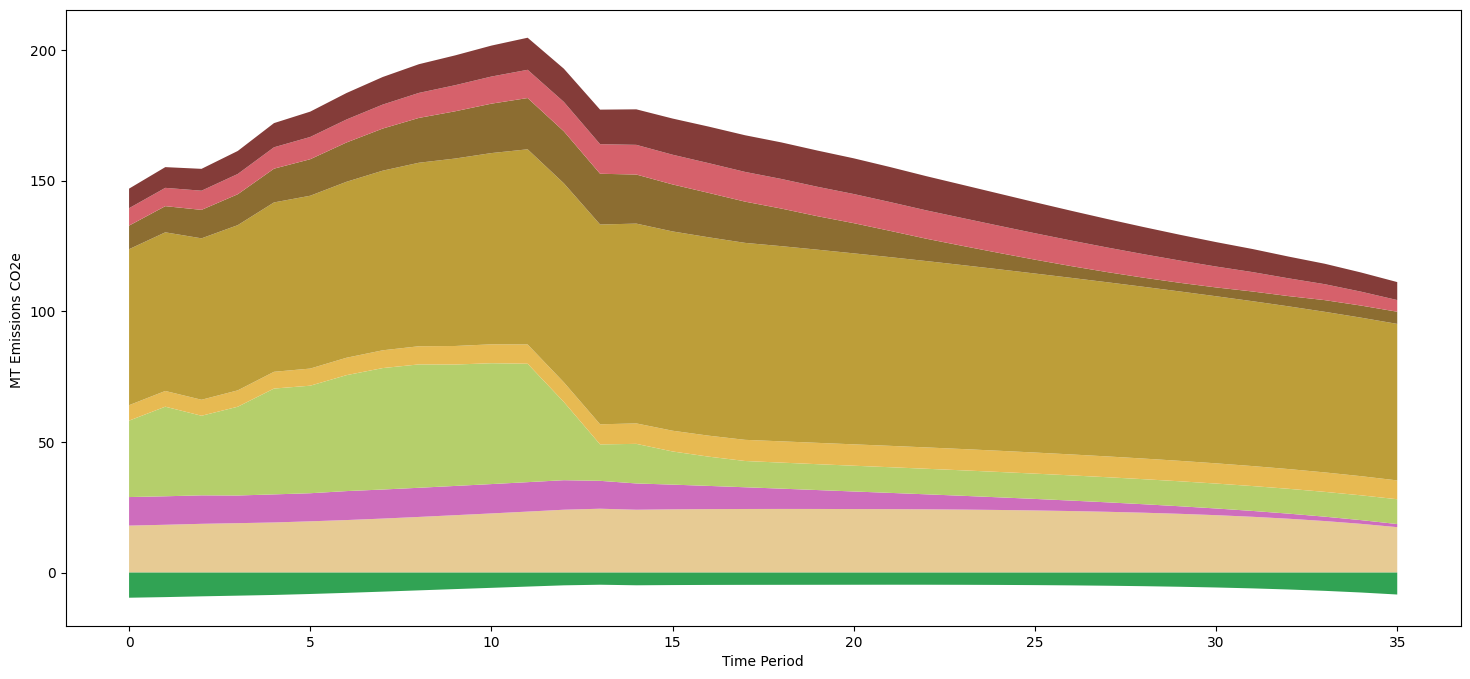

In [54]:

fig, ax = plt.subplots(figsize = (18, 8))
ax.set_xlabel("Time Period")
ax.set_ylabel("MT Emissions CO2e ")

df_plot = df_out[
    df_out[ssp.key_primary].isin([71071])
]


fields = matt.get_all_subsector_emission_total_fields()#[x for x in df_out.columns if (x.startswith("emission_co2e_subsector_total"))]
dict_format = dict(
    (k, {"color": v}) for (k, v) in
    matt.get_subsector_color_map().items()
)

fig, ax = spu.plot_stack(
    df_plot,
    fields,
    dict_formatting = dict_format,
    field_x = "time_period",
    figtuple = (fig, ax),
)


# Export Wide File (Last Mandatory Step)

In [55]:
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)


all_primaries = sorted(list(df_out[ssp.key_primary].unique()))

# build if unable to simply read the data frame
if df_in is None:
    df_in = []
     
    for region in ssp.regions:
        for primary in all_primaries: 
            df_in_filt = ssp.generate_scenario_database_from_primary_key(primary)
            df_in.append(df_in_filt.get(region))
    
    df_in = pd.concat(df_in, axis = 0).reset_index(drop = True)




df_export = pd.merge(
    df_out,
    df_in,
    how = "left",
)



# check output directory 
dir_pkg = os.path.join(
    ssp.file_struct.dir_out, 
    f"sisepuede_summary_results_run_{ssp.id_fs_safe}"
)
os.makedirs(dir_pkg) if not os.path.exists(dir_pkg) else None


for tab in ["ATTRIBUTE_STRATEGY"]:
    table_df = ssp.database.db.read_table(tab)
    if table_df is not None:
        table_df.to_csv(
            os.path.join(dir_pkg, f"{tab}.csv"),
            index=None,
            encoding="UTF-8"
        )
    else:
        print(f"Warning: Table {tab} returned None.")


df_primary = (
    ssp
    .odpt_primary
    .get_indexing_dataframe(
        sorted(list(df_out[ssp.key_primary].unique()))
    )
)
    
df_primary.to_csv(
    os.path.join(dir_pkg, f"ATTRIBUTE_PRIMARY.csv"),
    index = None,
    encoding = "UTF-8"
)

df_export.to_csv(
    os.path.join(dir_pkg, f"sisepuede_results_{ssp.id_fs_safe}_WIDE_INPUTS_OUTPUTS.csv"),
    index = None,
    encoding = "UTF-8"
)

In [56]:
# Getting the directory where the outputs are stored
ssp.file_struct.dir_out

'/home/tony-ubuntu/anaconda3/envs/ssp-data-env-2/lib/python3.11/site-packages/sisepuede/out'

## Some Optional Plotting

In [57]:
# primary_id = 0

# df_prim = df_out[
#     df_out[
#         ssp.key_primary
#     ]
#     .isin([primary_id])
# ]

# df_in_cur = df_in[
#     df_in[
#         ssp.key_primary
#     ]
#     .isin([primary_id])
# ]


# fields_plot = [
#     x for x in df_prim.columns
#     if "investment" in x
#     and df_prim[x].max() > 0
# ]
# (
#     df_prim[fields_plot]
#     .plot(
#         legend = True,
#     )
# )




In [58]:


# fig, ax = plt.subplots(figsize = (15, 10))
# df_resid = matt.extract_model_variable(
#     df_in_cur,
#     "NemoMod ResidualCapacity"
# )
# (
#     df_resid
#     .plot
#     .area(
#         ax = ax
#     )
# )

In [59]:
# df_resid

In [60]:
# [x for x in df_out.columns if "capacity" in x]

In [61]:
# ssp.model_attributes.configuration.dict_config


In [62]:
# modvar = matt.get_variable("NemoMod Generation Capacity")
# modvar.get_from_dataframe(df_prim).head()

In [63]:
# #[x for x in matt.all_variables if "Consumption" in x]
# [x for x in matt.all_variables if "Production" in x]
# modvar = matt.get_variable("NemoMod Production by Technology")


# unit = matt.get_unit("energy")
# (modvar.get_from_dataframe(df_prim).iloc[7].sum()*unit.convert("PJ", "mwh")/1000)/367669

In [64]:
# df_inputs

In [65]:
# modvar = matt.get_variable("Total Energy Consumption from Industrial Energy")#Industrial Energy")
# matt.extract_model_variable(
#     df_prim,
#     modvar
# )